# Facility Layout Problem
1) Model is trained <b>without input</b>: parameters only ;
2) Randn parameters initialization with <b>Boltzmann distribution</b> with <b>high temperature</b> (almost uniform distribution) ;
3) <b>Simulated Annealing</b> : worse loss solutions are sometimes accepted, according to temperature ;
4) <b>Noise addition</b> (partial, random parameter choice, decreasing with temperature) ;
5) <b>Custom Loss</b> function (Layout @ Layout.T @ Distances) ;
6) RMSprop optimizer.

In [188]:
########## Load libraries

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random

from functions.dataset import *
import importlib, sys

In [ ]:
#importlib.reload(sys.modules['functions.dataset'])
#from functions.dataset import *

### Perfect square layout

[[  7  45 103  98  22   3   1  18  28  53 136  17]
 [141 102 124  88 116  97  93  73  37 142 108  79]
 [ 96  54  52 113  80   2  60  74  16  32 140  83]
 [143  40  59  35  69  43 115  86 126 137  36   8]
 [ 12 101  66  61  81   4 132 129  70 120  10  51]
 [ 64  31 119  58 107  38   0  57  11 105 118  24]
 [122 135  48  77  89  78 123  63 110 125 134   9]
 [ 94 121 111  56  62  65  21  26 100  13  75  49]
 [ 82 128 130  46  25  55  44 109  87 139  76  19]
 [ 85  91  95 106  90 133  47  30  42  20  33 114]
 [ 99  39 104   6  92 127 138  14  34  27  72  71]
 [  5  84  15  50  41  23 112  68  29 117  67 131]]
Name    : Perfectly homogenous data
Groups  : 100
Edges   : 1386
Nodes   : 144



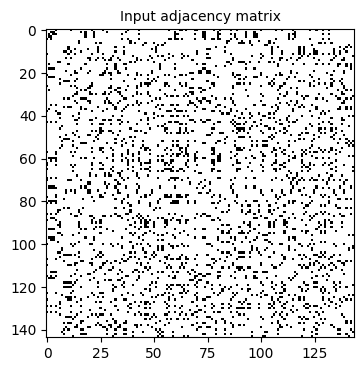

In [189]:
########## Define problem data
#.         M = optimal layout (hidden)
#.         natural_order = list(range(len(M)))
#.         AM = Adjacency matrix (Facility x Facility, shape M x M)
#.         D = Distances between locations (Location x Location, shape M x M)

N = 12
M = np.arange(N**2)
np.random.shuffle(M)
M = M.reshape((N,N))
print (M)

kernel = 3
groups = [M[i:i+kernel,ii:ii+kernel].ravel().tolist() 
            for i in range(M.shape[0]-kernel+1)
            for ii in range(M.shape[1]-kernel+1)]

random.shuffle(groups)

DS = DataSet("Perfectly homogenous data", groups)
print (DS)

natural_order = list(range(N**2))
DS.makeGraph("natural", natural_order)

spectral = nx.spectral_layout(DS.graphs['natural'].G, dim=1)
pos = [(k,v[0]) for k,v in spectral.items()]
pos_sorted = sorted(pos, key=lambda x : x[1])
spectral_order = [a[0] for a in pos_sorted]

kamada = nx.kamada_kawai_layout(DS.graphs['natural'].G, dim=1)
pos = [(k,v[0]) for k,v in kamada.items()]
pos_sorted = sorted(pos, key=lambda x : x[1])
kamada_order = [a[0] for a in pos_sorted]

order = natural_order

AM = DS.getAM(order)
_ = draw_adjacency_matrix(AM, title=f'Input adjacency matrix')

coords = np.argwhere(M>=0)[order]
D = np.zeros((N**2,N**2)).astype(float)
for i in range(N**2):
    dx = coords[i,0] - coords[:,0]
    dy = coords[i,1] - coords[:,1]
    D[i] = np.sqrt((dx**2) + (dy**2))


In [190]:
########## Model definition, initialization

adjacency_matrix = torch.tensor(AM, dtype=torch.float32) # Adjacency matrix (interaction weights)
distance_matrix = torch.tensor(D, dtype=torch.float32) # Distance matrix (Euclidean distances between locations)
L = adjacency_matrix.shape[0] # Number of facilities and locations

class FacilityLayoutNet(nn.Module):
    def __init__(self, num_facilities, num_locations):
        super(FacilityLayoutNet, self).__init__()
        self.num_facilities = num_facilities
        self.num_locations = num_locations
        
        initials = torch.rand((num_facilities, num_facilities), dtype=torch.float32)
        initials = self.boltzmann_probability(initials, 20000)
        self.logits = nn.Parameter(initials)
        
    def boltzmann_probability(self, E, T):
        exp_neg_E = torch.exp(-E / T)
        partition_function = torch.sum(exp_neg_E)
        V = exp_neg_E / partition_function
        return V

    def forward(self):
        probabilities = torch.softmax(self.logits, dim=1)
        return probabilities

def facility_layout_loss(probabilities, adjacency_matrix, distance_matrix):
    
    expected_distances = probabilities @ distance_matrix @ probabilities.T  # Shape: (N, N)
    loss = torch.sum(adjacency_matrix * expected_distances)
    overlap_penalty = torch.sum(probabilities.sum(dim=0) ** 2) - L  # Penalize multiple assignments to one location
    loss += 100.0 * overlap_penalty  # Weight for overlap penalty
    return loss

# Initialize the model
model = FacilityLayoutNet(L, L)
optimizer = optim.RMSprop(model.parameters(), lr=0.0001, alpha=0.99, momentum=0.9)

Epoch 4000/40000, Loss: 7081.875, Best Loss: 7081.8750, T° 18000.50
Epoch 8000/40000, Loss: 5292.919921875, Best Loss: 5292.9199, T° 16000.50
Epoch 12000/40000, Loss: 5262.85791015625, Best Loss: 5262.8579, T° 14000.50
Epoch 16000/40000, Loss: 5262.80078125, Best Loss: 5262.8008, T° 12000.50
Epoch 20000/40000, Loss: 5262.80029296875, Best Loss: 5262.8003, T° 10000.50
Epoch 24000/40000, Loss: 5262.8017578125, Best Loss: 5262.8018, T° 8000.51
Epoch 28000/40000, Loss: 5262.7998046875, Best Loss: 5262.7998, T° 6000.51
Epoch 32000/40000, Loss: 5262.80078125, Best Loss: 5262.8008, T° 4000.51
Epoch 36000/40000, Loss: 5262.80029296875, Best Loss: 5262.8003, T° 2000.51
Epoch 40000/40000, Loss: 5262.80029296875, Best Loss: 5262.8003, T° 0.51


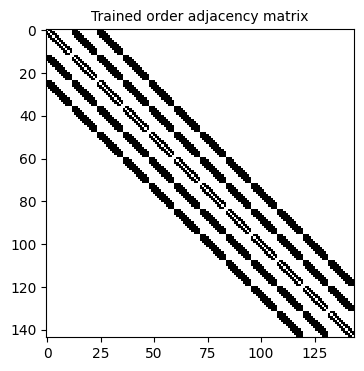


[[  5  99  85  82  94 122  64  12 143  96 141   7]
 [ 84  39  91 128 121 135  31 101  40  54 102  45]
 [ 15 104  95 130 111  48 119  66  59  52 124 103]
 [ 50   6 106  46  56  77  58  61  35 113  88  98]
 [ 41  92  90  25  62  89 107  81  69  80 116  22]
 [ 23 127 133  55  65  78  38   4  43   2  97   3]
 [112 138  47  44  21 123   0 132 115  60  93   1]
 [ 68  14  30 109  26  63  57 129  86  74  73  18]
 [ 29  34  42  87 100 110  11  70 126  16  37  28]
 [117  27  20 139  13 125 105 120 137  32 142  53]
 [ 67  72  33  76  75 134 118  10  36 140 108 136]
 [131  71 114  19  49   9  24  51   8  83  79  17]] Result

[[  7  45 103  98  22   3   1  18  28  53 136  17]
 [141 102 124  88 116  97  93  73  37 142 108  79]
 [ 96  54  52 113  80   2  60  74  16  32 140  83]
 [143  40  59  35  69  43 115  86 126 137  36   8]
 [ 12 101  66  61  81   4 132 129  70 120  10  51]
 [ 64  31 119  58 107  38   0  57  11 105 118  24]
 [122 135  48  77  89  78 123  63 110 125 134   9]
 [ 94 121 111  56  62

In [191]:
# Training loop
num_epochs = 40000
print_mod = int(num_epochs/10.)
initial_temperature = num_epochs / 2.
final_temperature = 0.01

best_loss = float('inf')
best_state = None

all_params = list(model.parameters())
num_params = len(all_params)

for epoch in range(num_epochs):
    
    temperature = initial_temperature - (epoch / num_epochs) * (initial_temperature - final_temperature)
    optimizer.zero_grad()
    probabilities = model()
    loss = facility_layout_loss(probabilities, adjacency_matrix, distance_matrix)
    
    # Simulated Annealing: Accept worse solutions with a probability based on temperature
    if torch.rand(1).item() < torch.exp(torch.tensor(-(loss.item() - best_loss) / temperature)):
        best_loss = loss.item()
        best_state = model.state_dict()
        
    loss.backward()
    
    # add some noise
    for param in model.parameters():
        random_indices = random.sample(range(num_params), num_params // 3)
        param.grad[random_indices] += torch.randn_like(param.grad[random_indices]) * 1e-04 * np.log(temperature+1)
    
    optimizer.step()
    
    if (epoch + 1) % print_mod == 0:
        s1 = f"Epoch {epoch + 1 : 6d}/{num_epochs : 6d}"
        s2 = f"Loss: {loss.item() : 10.4f}"
        s3 = f"Best Loss: {best_loss: 10.4f}"
        s4 = f"T° {temperature: 10.2f}"
        print(f"{s1} | {s2}, {s3}, {s4}")
        
# Final facility-to-location assignments
model.load_state_dict(best_state)  # Load the best state
final_probabilities = model().detach()
assignments = torch.argmax(final_probabilities, dim=1)

assign = assignments.detach().tolist()
assign = list(a for a in zip(list(range(len(assign))), assign))
assign.sort(key=lambda x: x[1])

trained_order = [a[0] for a in assign]
oAM = DS.getAM(trained_order)
_ = draw_adjacency_matrix(oAM, title=f'Trained order adjacency matrix')

print ("")
print (np.array([a[0] for a in assign]).reshape((N,N)), 'Result')
print ("")
print (M, 'Truth')

### "O" Layout - parts missing

In [ ]:
importlib.reload(sys.modules['functions.dataset'])
from functions.dataset import *

[[ 40 125  14 116  47 110  88  17 105  16   5  90]
 [ 79  85  64  34  75  13 132 104 133  72 141  30]
 [ 76  70  99 117  38 123 107 139  25  48  33 111]
 [ 24  63   1  27  22 142  57  80 130  71 137 120]
 [ 44   9 136  95  52 134 124  18  54 100  81  59]
 [ 83  92  62 131 122 118  50   7  28 129 115  67]
 [101  91  68 112 106  36  65  23  49  86 103  32]
 [128  19  98  73  10  53 143  82  94 135  55   6]
 [ 41  89 113  97 119  11 126  20  56  42   2  61]
 [114 109  46   8  37  45   4 127   3  35  12  58]
 [ 66  43  77  69 138  51  15 102  84  26 121  29]
 [ 60  39 108  21  78  31   0  93  96 140  87  74]]
Name    : O-data
Groups  : 100
Edges   : 1092
Nodes   : 144



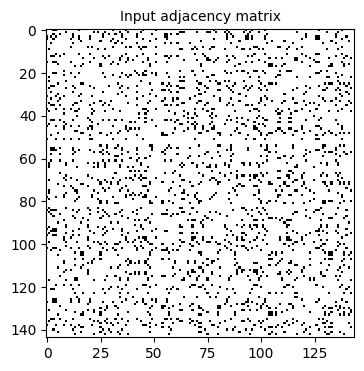

0


In [192]:
########## Define problem data
#.         M = optimal layout (hidden)
#.         natural_order = list(range(len(M)))
#.         AM = Adjacency matrix (Facility x Facility, shape M x M)
#.         D = Distances between locations (Location x Location, shape M x M)

N = 12
M = np.arange(N**2)
np.random.shuffle(M)
M = M.reshape((N,N))
print (M)

m = np.ones(M.shape).astype(bool)
m[4:8,4:8] = 0

kernel = 3
groups = [M[i:i+kernel,ii:ii+kernel][m[i:i+kernel,ii:ii+kernel]].ravel().tolist() 
            for i in range(M.shape[0]-kernel+1)
            for ii in range(M.shape[1]-kernel+1)]

"""
kernel = 2
groups2 = [M[i:i+kernel,ii:ii+kernel][~m[i:i+kernel,ii:ii+kernel]].ravel().tolist() 
            for i in range(M.shape[0]-kernel+1)
            for ii in range(M.shape[1]-kernel+1)]

groups = groups1 + groups2
"""

random.shuffle(groups)

DS = DataSet("O-data", groups)

natural_order = list(range(N**2))
order = natural_order

voids = list(set(natural_order)-set(DS.nodes))
DS.nodes += voids
random.shuffle(DS.nodes)
DS._adjacencyTable()

print (DS)
AM = DS.getAM(order)

"""
for idx in voids:
    AM[voids,idx] += 0.1
    AM[idx,voids] += 0.1
"""
_ = draw_adjacency_matrix(AM, title=f'Input adjacency matrix')

coords = np.argwhere(M>=0)[order]
D = np.zeros((N**2,N**2)).astype(float)
#Z = (~m*100).astype(int).ravel() # Z introduces a second "level" -> known shape
for i in range(N**2):
    dx = coords[i,0] - coords[:,0]
    dy = coords[i,1] - coords[:,1]
    # dz = Z[i] - Z[:]
    D[i] = np.sqrt((dx**2) + (dy**2))

print (Z[0])

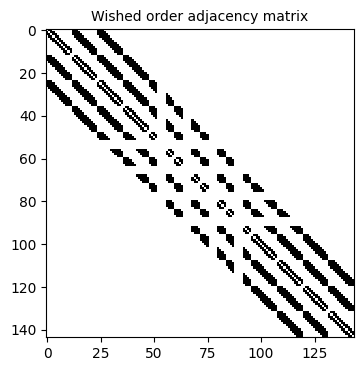

tensor(4087.5964)


In [193]:
grid_order = M.ravel().tolist()
wished = DS.getAM(grid_order)
probabilities = torch.zeros(AM.shape, dtype=torch.float32)
probabilities[grid_order, list(range(len(grid_order)))] = 1.

_ = draw_adjacency_matrix(wished, title=f'Wished order adjacency matrix')

adjacency_matrix = torch.tensor(AM, dtype=torch.float32) # Adjacency matrix (interaction weights)
distance_matrix = torch.tensor(D, dtype=torch.float32) # Distance matrix (Euclidean distances between locations)
loss = facility_layout_loss(probabilities, adjacency_matrix, distance_matrix)
print (loss)


In [205]:
########## Model definition

adjacency_matrix = torch.tensor(AM, dtype=torch.float32) # Adjacency matrix (interaction weights)
distance_matrix = torch.tensor(D, dtype=torch.float32) # Distance matrix (Euclidean distances between locations)
L = adjacency_matrix.shape[0] # Number of facilities and locations

########## Initialize

model = FacilityLayoutNet(L, L)
optimizer = optim.RMSprop(model.parameters(), lr=1e-04, alpha=0.99, momentum=0.9)

Epoch   5000/ 50000 | Loss:  4861.0342, Best Loss:  4861.0342, T°   22500.50
Epoch  10000/ 50000 | Loss:  4316.9194, Best Loss:  4316.9194, T°   20000.50
Epoch  15000/ 50000 | Loss:  4307.0986, Best Loss:  4307.0986, T°   17500.50
Epoch  20000/ 50000 | Loss:  4306.2046, Best Loss:  4306.2046, T°   15000.50
Epoch  25000/ 50000 | Loss:  4305.4058, Best Loss:  4305.4058, T°   12500.50
Epoch  30000/ 50000 | Loss:  4305.1367, Best Loss:  4305.1367, T°   10000.50
Epoch  35000/ 50000 | Loss:  4305.0298, Best Loss:  4305.0298, T°    7500.50
Epoch  40000/ 50000 | Loss:  4304.9751, Best Loss:  4304.9751, T°    5000.50
Epoch  45000/ 50000 | Loss:  4304.9634, Best Loss:  4304.9634, T°    2500.50
Epoch  50000/ 50000 | Loss:  4304.9644, Best Loss:  4304.9644, T°       0.50


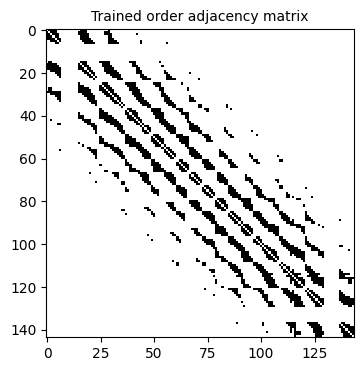


[[ 90  30 141   5  16 105  17 118 134  23  36  10]
 [ 52  65 124 120 111  33  72 133 104  88 110 116]
 [106  67  59 137  71  48  25 139 132  13  47  14]
 [ 40   6  32 115  81 100 130  80 107  75  34  64]
 [125  61  55 103  86 129  54  57 123  38 117  99]
 [ 85  58   2 135  94  49  28 142  22  27   1  70]
 [ 79  29  12  42  56  20 126 112 131  95 136  63]
 [ 76 121  35   3 127   4  11  73  68  62  92   9]
 [ 24  87  26  84 102  45 119  97  98  19  91  83]
 [ 44  74 140  93  15  51   8  37  46 113  89 128]
 [101  96   0  31 138  69  77 109 114  41 122   7]
 [ 18  50  53  82 143  78  21 108  39  43  66  60]] Result

[[ 40 125  14 116  47 110  88  17 105  16   5  90]
 [ 79  85  64  34  75  13 132 104 133  72 141  30]
 [ 76  70  99 117  38 123 107 139  25  48  33 111]
 [ 24  63   1  27  22 142  57  80 130  71 137 120]
 [ 44   9 136  95  52 134 124  18  54 100  81  59]
 [ 83  92  62 131 122 118  50   7  28 129 115  67]
 [101  91  68 112 106  36  65  23  49  86 103  32]
 [128  19  98  73  10

In [206]:
# Training loop
num_epochs = 50000
print_mod = int(num_epochs/10.)
initial_temperature = num_epochs / 2.
final_temperature = 0.001

best_loss = float('inf')
best_state = None

all_params = list(model.parameters())
num_params = len(all_params)

for epoch in range(num_epochs):
    
    temperature = initial_temperature - (epoch / num_epochs) * (initial_temperature - final_temperature)
    optimizer.zero_grad()
    probabilities = model()
    loss = facility_layout_loss(probabilities, adjacency_matrix, distance_matrix)
    
    # Simulated Annealing: Accept worse solutions with a probability based on temperature
    if torch.rand(1).item() < torch.exp(torch.tensor(-(loss.item() - best_loss) / temperature)):
        best_loss = loss.item()
        best_state = model.state_dict()
        
    loss.backward()
    
    # add some noise
    for param in model.parameters():
        random_indices = random.sample(range(num_params), num_params)
        param.grad[random_indices] += torch.randn_like(param.grad[random_indices]) * 1e-03 * np.log(temperature+1)
    
    optimizer.step()
    
    if (epoch + 1) % print_mod == 0:
        s1 = f"Epoch {epoch + 1 : 6d}/{num_epochs : 6d}"
        s2 = f"Loss: {loss.item() : 10.4f}"
        s3 = f"Best Loss: {best_loss: 10.4f}"
        s4 = f"T° {temperature: 10.2f}"
        print(f"{s1} | {s2}, {s3}, {s4}")

# Final facility-to-location assignments
model.load_state_dict(best_state)  # Load the best state
final_probabilities = model().detach()
assignments = torch.argmax(final_probabilities, dim=1)

assign = assignments.detach().tolist()
assign = list(a for a in zip(list(range(len(assign))), assign))
assign.sort(key=lambda x: x[1])

trained_order = [a[0] for a in assign]
oAM = DS.getAM(trained_order)
_ = draw_adjacency_matrix(oAM, title=f'Trained order adjacency matrix')

print ("")
print (np.array([a[0] for a in assign]).reshape((N,N)), 'Result')
print ("")
print (M, 'Truth')